#**WaveNet Explained**


---


WaveNet is a deep neural network model for generating raw audio waveforms. It's a generative model, meaning it can create new audio from scratch. Key features of WaveNet include:

- Dilated Causal Convolutions: These allow the model to have a large receptive field (the portion of the input it considers for each output) without using pooling layers, which can reduce temporal resolution. The convolutions are causal, meaning the prediction at a given time step only depends on previous time steps, making it suitable for autoregressive generation.
- Autoregressive Generation: WaveNet generates audio sample by sample, predicting the probability distribution for the next audio sample based on the previous samples.
- Skip Connections: These help to speed up training and allow gradients to flow more easily through the network.
Gated Activation Units: Similar to gates in LSTMs, these help the model to control the flow of information.
- µ-law Companding: This is a non-linear quantization technique used to represent the audio signal with fewer bits while preserving perceptual quality.

In this assignment, we will implement a simplified version of the WaveNet architecture for autoregressive audio generation. Note that training the full model requires a significant amount of computational resources. If you are interested, you can explore the following GitHub repository, which provides a complete implementation. You can download it and train it locally, as training on the free tier of Colab is not practical.

https://github.com/ibab/tensorflow-wavenet



##Importing required libraries

The first step is to import the required libraries.

In [ ]:
# ---------------------------
# Import required libraries
# ---------------------------
"""
    If you are training locally, or if Google Colab does not recognize any library, you can install it using the following commands:

    In google colab:
    !pip install library_name

    In your pc:
    pip install library_name
"""


import os
import tarfile
import urllib.request
import numpy as np
import librosa
import soundfile as sf
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, Multiply, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

import random

## Setting parameters


In [1]:
# ---------------------------
# Parameters
# ---------------------------
SAMPLE_RATE = 16000
DATA_PATH = './'
AUDIO_DIR = './wavs'
DOWNLOAD_URL = 'http://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2'
TRAIN_SPLIT = 0.8
EPOCHS = 100
BATCH_SIZE = 32
NUM_QUANTIZATION_BINS = 256
DILATIONS = (1, 2, 4, 8, 16, 32)
RESIDUAL_CHANNELS = 64
SKIP_CHANNELS = 128
KERNEL_SIZE = 2


## Downloading dataset for training


In [ ]:
# ---------------------------
# Download and extract LJSpeech-1.1 dataset
# ---------------------------
# print(f"Downloading {DOWNLOAD_URL}...")
# urllib.request.urlretrieve(DOWNLOAD_URL, os.path.join(DATA_PATH, 'LJSpeech-1.1.tar.bz2'))
# print("Download completed.")
# print("Extracting...")
# with tarfile.open(os.path.join(DATA_PATH, 'LJSpeech-1.1.tar.bz2'), 'r:bz2') as tar:
#     tar.extractall(DATA_PATH)
# !mv ./LJSpeech-1.1/wavs ./wavs
# !rm -rf ./LJSpeech-1.1 LJSpeech-1.1.tar.bz2
# print("Extraction completed.")

# Download a small chunk of daLJSpeech-1.1 data
# print(f"Downloading {DOWNLOAD_URL}...")
# !wget https://github.com/rezaghasemi/GenAI-audio-module/raw/refs/heads/main/wavs.zip -O wavs.zip
# print("Download completed.")
# print("Extracting...")
# Step 2: Unzip it
# !unzip -q wavs.zip
# !rm wavs.zip
# print("Extraction completed.")

zsh:1: command not found: wget


## μ-law Encoding and Decoding

μ-law encoding is a non-linear quantization technique used in digital telecommunication systems to compress analog signals, such as audio, before digitization. It's particularly useful for voice signals, where smaller amplitude values are more common than larger ones.

The key idea behind μ-law encoding is to apply a logarithmic compression to the signal. This gives finer resolution to smaller signals and coarser resolution to larger signals. This non-linear mapping allows a signal with a wide dynamic range to be effectively represented with a smaller number of bits, thus reducing the bandwidth required for transmission or storage.

In [ ]:
# ---------------------------
# µ-law encode / decode
# ---------------------------
def mu_law_encode(audio, quantization_channels=256):
    mu = quantization_channels - 1
    audio = np.clip(audio, -1.0, 1.0)
    encoded = np.sign(audio) * np.log1p(mu * np.abs(audio)) / np.log1p(mu)
    return ((encoded + 1) / 2 * mu).astype(np.int32)

def mu_law_decode(encoded, quantization_channels=256):
    mu = quantization_channels - 1
    y = encoded.astype(np.float32)
    y = 2 * (y / mu) - 1
    return np.sign(y) * (1 / mu) * ((1 + mu) ** np.abs(y) - 1)

## WaveNet Architecture Explanation

The core idea of WaveNet is to use a stack of **dilated causal convolutions** to increase the receptive field of the network without increasing the number of layers proportionally. This allows the model to capture long-range dependencies in the audio signal efficiently.

Here's a breakdown of the key components and how they work together in the provided simplified WaveNet architecture:

1.  **Input Layer**: The model takes a 1D input representing the audio signal. Since it's an autoregressive model, at inference time, the input will be a sequence of previous audio samples. The input shape is `(receptive_field, 1)`, where `receptive_field` is the number of previous samples the model considers to predict the next one.

2.  **Initial Causal Convolution**: A `Conv1D` layer with `kernel_size=1` and `padding='causal'` is applied to the input. The causal padding ensures that the output at a given time step only depends on the current and previous time steps. This initial convolution prepares the input for the subsequent dilated convolutional layers.

3.  **Dilated Causal Convolutional Blocks**: The main building blocks of the network are the dilated causal convolutional layers. These layers are stacked with increasing dilation rates (`DILATIONS`).
    *   **Dilated Convolutions**: These convolutions have gaps between the kernel elements. This allows the network to cover a larger area of the input sequence with fewer layers compared to standard convolutions. The dilation rate doubles in each subsequent layer in the stack (e.g., 1, 2, 4, 8, ...), exponentially increasing the receptive field.
    *   **Causal Padding**: The `padding='causal'` argument ensures that the output at a given time step is only influenced by input elements at the current and previous time steps. This is crucial for autoregressive models where the prediction for the next sample can only depend on past samples.
    *   **Gated Activation Units**: Each dilated convolution is followed by a gated activation unit, which is a multiplication of the outputs of two separate dilated convolutions with different activation functions (tanh and sigmoid). This gating mechanism helps the model selectively allow information to pass through, similar to the gates in LSTMs.

4.  **Residual Connections**: Residual connections (`Add` layer) are used within each dilated convolutional block. The output of the gated activation unit is added to the input of the block. These connections help in training deeper networks by allowing gradients to flow more easily through the network and prevent vanishing gradients.

5.  **Skip Connections**: Skip connections are also used, but they bypass the residual blocks and directly connect the output of each dilated convolutional block (after a 1x1 convolution) to a final output layer. These skip connections contribute to the final prediction by aggregating features from different layers of the network.

6.  **Output Layers**:
    *   The outputs of all the skip connections are summed up (`Add` layer).
    *   This sum is passed through a `ReLU` activation.
    *   Two `Conv1D` layers with `kernel_size=1` and `padding='causal'` are applied. These layers serve as the final transformation before the output layer.
    *   A final `Conv1D` layer with `kernel_size=1` and `padding='causal'` outputs the logits for each of the `num_quantization_bins`.
    *   A `Softmax` activation is applied to the logits to produce a probability distribution over the possible next audio sample values.

7.  **Autoregressive Prediction**: For autoregressive generation, the model is designed to predict only the probability distribution for the *last* time step of the input sequence. This prediction is then used to sample the next audio sample, which is then appended to the input sequence for the next prediction step. The model output `y_last = y[:, -1, :]` reflects this, taking only the prediction for the last time step.

The model is compiled with the Adam optimizer and `SparseCategoricalCrossentropy` loss, which is suitable for predicting one of the discrete `num_quantization_bins`. The receptive field of the model is determined by the kernel size and the dilation rates, indicating how many previous samples the model considers for each prediction.

In [ ]:
def create_wavenet_ar_model(
    num_quantization_bins,
    dilations=DILATIONS,
    residual_channels=RESIDUAL_CHANNELS,
    skip_channels=SKIP_CHANNELS,
    kernel_size=KERNEL_SIZE,
    learning_rate=2e-3,
):
    # Compute receptive field
    receptive_field = 1 + (kernel_size - 1) * sum(dilations)

    # Input shape matches the receptive field
    input_shape = (receptive_field, 1)
    x_in = Input(shape=input_shape, name="audio_in")
    x = Conv1D(residual_channels, kernel_size=1, padding='causal', name="causal_prep")(x_in)
    skip_outputs = []

    for i, d in enumerate(dilations):
        filt = Conv1D(residual_channels, kernel_size=kernel_size, dilation_rate=d, padding='causal')(x)
        gate = Conv1D(residual_channels, kernel_size=kernel_size, dilation_rate=d, padding='causal')(x)
        z = Multiply()([Activation('tanh')(filt), Activation('sigmoid')(gate)])
        skip_outputs.append(Conv1D(skip_channels, kernel_size=1, padding='causal')(z))
        x = Add()([x, Conv1D(residual_channels, kernel_size=1, padding='causal')(z)])

    x = Add()(skip_outputs) if len(skip_outputs) > 1 else skip_outputs[0]
    x = ReLU()(x)
    x = Conv1D(skip_channels, kernel_size=1, padding='causal')(x)
    x = ReLU()(x)
    logits = Conv1D(num_quantization_bins, kernel_size=1, padding='causal')(x)
    y = Activation('softmax')(logits)

    # Only last timestep is used for AR prediction
    y_last = y[:, -1, :]
    model = Model(inputs=x_in, outputs=y_last, name="WaveNet_AR")
    model.compile(optimizer=Adam(learning_rate), loss=SparseCategoricalCrossentropy(), metrics=[])

    return (model, receptive_field)


## Initializing the model

In [ ]:
# ---------------------------
# Initialize model
# ---------------------------
model, receptive_field = create_wavenet_ar_model(
    num_quantization_bins=NUM_QUANTIZATION_BINS,
)
print("Use this receptive field for data preprocessing:", receptive_field)
# model.summary()

Use this receptive field for data preprocessing: 64


## Loading and processing the data

In [ ]:
# ---------------------------
# Load and µ-law preprocess audio
# ---------------------------
audio_files = [os.path.join(AUDIO_DIR, f) for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')]
preprocessed_audio = []

for audio_file in tqdm(audio_files, desc="Processing data: Load and µ-law"):
    try:
        audio, sr = librosa.load(audio_file, sr=None)
        if sr != SAMPLE_RATE:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
        audio = librosa.util.normalize(audio)
        encoded_audio = mu_law_encode(audio, quantization_channels=NUM_QUANTIZATION_BINS)
        preprocessed_audio.append(encoded_audio)
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
print(f"Loaded and encoded {len(preprocessed_audio)} audio files.")

# ---------------------------
# Generate training samples
# ---------------------------
X, y = [], []
for audio in tqdm(preprocessed_audio, desc="Processing data: Extracting samples"):
    if len(audio) < receptive_field + 1:
        padding_needed = (receptive_field + 1) - len(audio)
        audio = np.pad(audio, (0, padding_needed), mode='constant')
    for start in range(0, len(audio) - receptive_field):
        end = start + receptive_field
        X.append(audio[start:end])
        y.append(audio[end])

X = np.expand_dims(np.array(X, dtype=np.float32), axis=-1)  # (batch, receptive_field, 1)
y = np.array(y, dtype=np.int32).squeeze()                   # (batch,) for SparseCategoricalCrossentropy

split_idx = int(len(X) * TRAIN_SPLIT)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]


# X_train = X_train[:100, :, :]
# y_train = y_train[:100]

# X_val = X_val[:20, :, :]
# y_val = y_val[:20]

print(f"Training samples: {X_train.shape}, {y_train.shape}")
print(f"Validation samples: {X_val.shape}, {y_val.shape}")

Loaded and encoded 90 audio files.


100%|██████████| 90/90 [00:06<00:00, 14.07it/s]


Training samples: (100, 64, 1), (100,)
Validation samples: (20, 64, 1), (20,)


## Visualizing the training and validating loss during training

In [ ]:
class RealTimeBatchMetrics(Callback):
    def __init__(self, update_every=1):
        """
        Args:
            update_every: Update plot every `update_every` batches
        """
        super().__init__()
        self.update_every = update_every
        self.batch_losses = []
        self.batch_accuracies = []
        self.epoch_losses = []
        self.epoch_accuracies = []
        self.epoch_val_losses = []
        self.epoch_val_accuracies = []

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.batch_losses.append(logs.get('loss'))

        if (batch + 1) % self.update_every == 0:
            clear_output(wait=True)
            plt.figure(figsize=(12, 10))

            # Plot Batch Loss
            plt.subplot(2, 2, 1)
            plt.plot(self.batch_losses, label='Train Loss (Batch)')
            plt.xlabel('Batch')
            plt.ylabel('Loss')
            plt.title('Training Loss (Batch)')
            plt.legend()
            plt.grid(True)

            # Plot Epoch Loss
            plt.subplot(2, 2, 2)
            plt.plot(self.epoch_losses, label='Train Loss (Epoch)')
            plt.plot(self.epoch_val_losses, label='Val Loss (Epoch)')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training & Validation Loss (Epoch)')
            plt.legend()
            plt.grid(True)



            plt.tight_layout()
            plt.show()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))

## Training the model

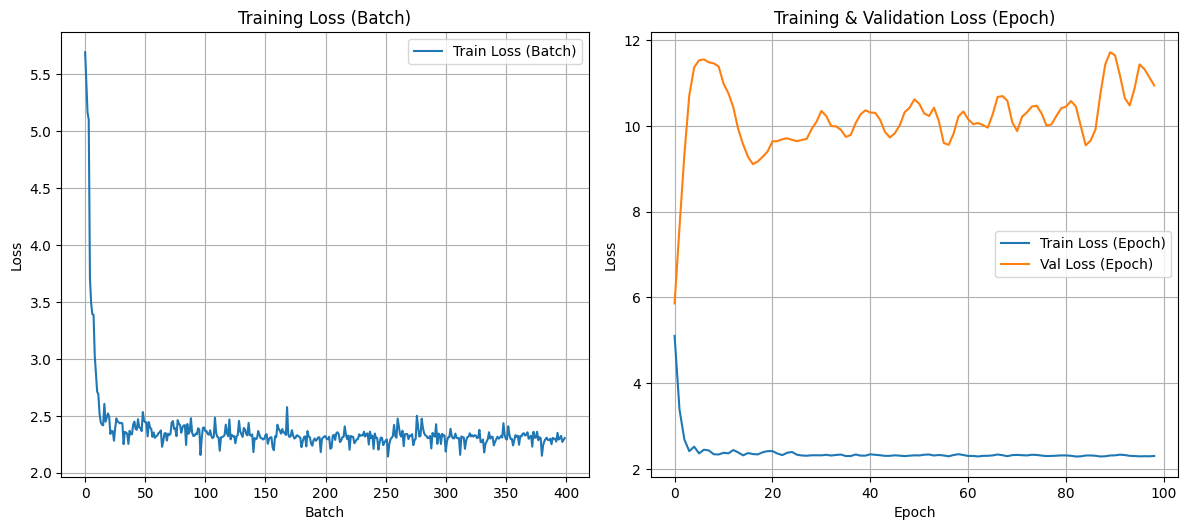

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - loss: 2.2972 - val_loss: 10.5670


In [ ]:
# ---------------------------
# Train model
# ---------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[RealTimeBatchMetrics(update_every=1)],
    shuffle=True,
    verbose=1
)

## Generating a sample

In [ ]:
# ---------------------------
# Audio generation
# ---------------------------
def generate_audio(model, initial_sequence, output_length, quantization_bins=NUM_QUANTIZATION_BINS):
    """Generate audio autoregressively."""
    generated = initial_sequence.copy()
    for _ in tqdm(range(output_length), desc="Generating Sample..."):
        input_seq = generated[:, -receptive_field:, :]
        probs = model.predict(input_seq, verbose=0)[0]  # shape: (NUM_QUANTIZATION_BINS,)
        sampled_bin = np.random.choice(quantization_bins, p=probs)
        sampled_bin = np.array(sampled_bin).reshape(1,1,1)
        generated = np.concatenate((generated, sampled_bin), axis=1)
    return mu_law_decode(generated[0, initial_sequence.shape[1]:, 0], quantization_channels=quantization_bins)

##Generate a Sample from the Current Files

If no initial sequence is provided, the code will automatically select a sample and use its beginning portion as the starting sequence.

In [ ]:
# ---------------------------
# Generate a sample
# ---------------------------

# Choose a random audio file from the preprocessed audio list
random_index = random.randint(0, len(preprocessed_audio) - 1)
initial_audio_encoded = preprocessed_audio[random_index]

# Ensure the initial sequence is at least receptive_field + 1 long
if len(initial_audio_encoded) < receptive_field + 1:
    padding_needed = (receptive_field + 1) - len(initial_audio_encoded)
    initial_audio_encoded = np.pad(initial_audio_encoded, (0, padding_needed), mode='constant')

# Take the first 'receptive_field' samples as the initial sequence for generation
initial_sequence_for_generation = initial_audio_encoded[:receptive_field]

# Reshape for the model input (batch_size=1, receptive_field, 1)
initial_sequence_for_generation = np.expand_dims(np.expand_dims(initial_sequence_for_generation, axis=-1), axis=0)


# Define the length of the audio to generate (e.g., 3 seconds)
output_length_seconds = 3
output_length_samples = output_length_seconds * SAMPLE_RATE

# Generate the audio
generated_audio = generate_audio(model, initial_sequence_for_generation, output_length_samples, NUM_QUANTIZATION_BINS)

# Save the generated audio
output_filename = "generated_sample.wav"
sf.write(output_filename, generated_audio, SAMPLE_RATE)

print(f"Generated audio sample saved as '{output_filename}'")